In [1]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import mlflow
import mlflow.sklearn
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, classification_report, confusion_matrix, make_scorer
import matplotlib.pyplot as plt
from scipy.stats import randint
import dagshub

In [2]:
# set up dagshub for mlflow tracking
dagshub.init(repo_owner='JonaKoenemann', repo_name='machine_failure_classification', mlflow=True)


Initialized MLflow to track repo "JonaKoenemann/machine_failure_classification"

Repository JonaKoenemann/machine_failure_classification initialized!

# Data preparation

In [3]:
data_path = "../../../data/predictive_maintenance.csv"

In [4]:
df = pd.read_csv(data_path)

In [5]:
categorical_features = ['Type']
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
numerical_features.remove('UDI')
numerical_features.remove('Target')

# Feature Engineering: Polynomial Features
poly = PolynomialFeatures(degree=2, include_bias=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('poly', poly)
        ]), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

In [6]:
# Split for features (X) und labels (y)
X = df[numerical_features + categorical_features] # select Features 
y = df["Failure Type"]

In [7]:
# Split for test and train data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Test preprocessor pipeline
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

print(X_train_transformed.shape)
print(X_test_transformed.shape)

(8000, 23)
(2000, 23)


# Train and test

In [9]:
mlflow.set_experiment("gradient_boosting_classifier_rs_feature")

mlflow.sklearn.autolog()

model = GradientBoostingClassifier(random_state=42)

param_distributions = {
    'model__loss': ['log_loss'], 
    'model__learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'model__n_estimators': [100, 150, 250, 300],
    'model__max_depth': random.choice([None, randint(10, 30)]), # None or integer between 10 and 30
    'model__min_samples_split': randint(2, 10),
    'model__min_samples_leaf': randint(1, 5)
}

# Define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

# weighted f1 score as scoring metric
scorer = make_scorer(f1_score, average = "weighted")


In [10]:
with mlflow.start_run():    
    # Set up RandomizedSearchCV
    randomized_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_distributions,
                                           n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1, scoring=scorer)

    # Fit RandomizedSearchCV
    randomized_search.fit(X_train, y_train)

    # Get the best parameters
    best_params = randomized_search.best_params_
    mlflow.log_params(best_params)

    # Get the best model
    best_model = randomized_search.best_estimator_

    # predicition
    y_pred = best_model.predict(X_test)

    # evaluation
    weighted_f1 = f1_score(y_true = y_test, y_pred= y_pred, average="weighted")
    print("\nweighted f1 score:", weighted_f1)
    mlflow.log_metric('weighted_f1_score', weighted_f1)
    
    mlflow.end_run()


2024/06/30 20:10:46 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\jkoenemann\GitHub\machine_failure_classification\venv\Lib\site-packages\mlflow\data\digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead."
2024/06/30 20:11:42 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\jkoenemann\GitHub\machine_failure_classification\venv\Lib\site-packages\mlflow\types\utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these colum

Fitting 5 folds for each of 100 candidates, totalling 500 fits


c:\Users\jkoenemann\GitHub\machine_failure_classification\venv\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
275 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
275 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\jkoenemann\GitHub\machine_failure_classification\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\jkoenemann\GitHub\machine_failure_classification\venv\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  


weighted f1 score: 0.9736769105244824


# Evaluation

In [11]:
error_names = [
 'Heat Failure',
 'No Failure',
 'Overstrain Failure',
 'Power Failure',
 'Random Failure',
 'Tool wear Failure'] # get names of errors in correct order for confusion matrix

## Classification report

In [12]:
print("Classification Report:")
report = classification_report(y_test, y_pred)
print(report)

Classification Report:
                          precision    recall  f1-score   support

Heat Dissipation Failure       0.87      0.87      0.87        15
              No Failure       0.99      0.99      0.99      1935
      Overstrain Failure       0.70      0.54      0.61        13
           Power Failure       0.83      0.75      0.79        20
         Random Failures       0.00      0.00      0.00         6
       Tool Wear Failure       0.12      0.09      0.11        11

                accuracy                           0.97      2000
               macro avg       0.59      0.54      0.56      2000
            weighted avg       0.98      0.97      0.97      2000



# Normalized consuion matrix

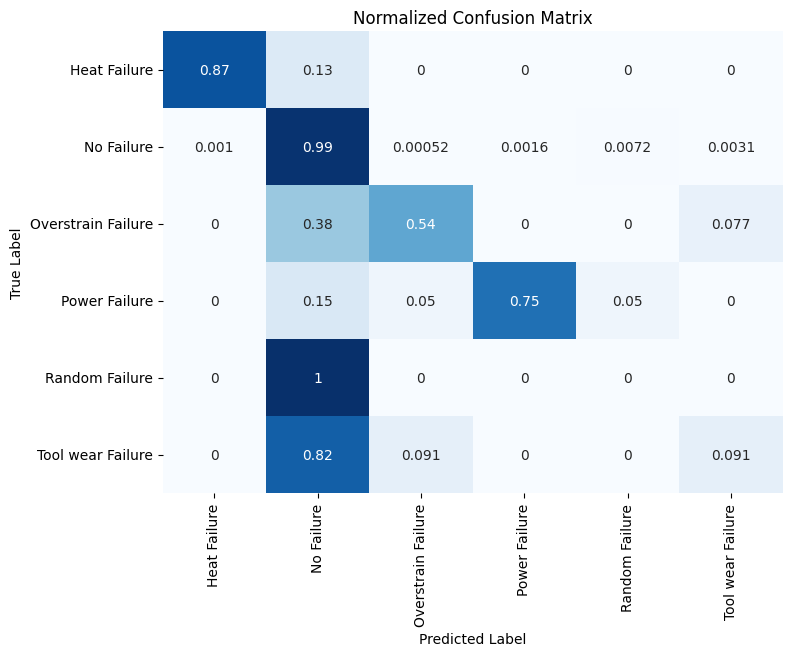

In [13]:
conf_matrix_normalized = confusion_matrix(y_test, y_pred, normalize='true')

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, cmap="Blues", cbar=False, xticklabels=error_names, yticklabels=error_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix")
plt.show()